In [14]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

# #sklearnex
# from sklearnex import patch_sklearn
# patch_sklearn()
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# StratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import (accuracy_score,
                            recall_score,
                            precision_score,
                            f1_score,
                            roc_auc_score,
                            roc_curve,
                            matthews_corrcoef,
)
import cv2 as cv
from radiomics import featureextractor
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler

#Import paths and patients classes
from notebooks.info import path_label, patient
import notebooks.utils as utils

In [59]:
def get_ex_included(budget_path: Path):
    """get excluded features name using the budget CV value

    Args:
        budget_path (Path): path to the csv file with the budget

    Returns:
        sequences: excluded and included features
    """
    # get the name of the features from the budget
    budget = pd.read_excel(budget_path, index_col=0)
    # change name of column
    budget.columns = ['budget']
    # get all features with values greater than 1
    excluded = budget[budget[ 'budget' ] > 1].index
    # get all other names
    included = budget[budget[ 'budget' ] <= 1].index
    
    return excluded, included

def get_features(stype:str, excluded:list):
    """
    return df with features given the segmentation type and excluded features

    Args:
        stype (str): general or focal
        excluded (seq): sequence of excluded features

    Returns:
        pd.DataFrame: df with features
    """
    # get features
    features = pd.read_csv(repo_path / 'data' / 'features' / f'features_all_time{stype}.csv', index_col=0)
    features = features.groupby(by='pat_num', axis=0).mean()
    # remove features in excluded list
    features = features.drop(excluded, axis=1)

    return features


def best_threshold(fpr, tpr, thresholds):
    """given the roc curve information, it returns the best threshold accoridng to the gmean

    Args:
        fpr (np.array): false positiva rate values
        tpr (np.array): true positive rate values
        thresholds (np.array): thresholds found for the ROC curve

    Returns:
        float: optimal threshold
    """
    # Calculate the G-mean
    gmean = np.sqrt(tpr * (1 - fpr))
    # Find the optimal threshold
    index = np.argmax(gmean)
    thresholdOpt = round(thresholds[index], ndigits = 4)
    # gmeanOpt = round(gmean[index], ndigits = 4)
    # fprOpt = round(fpr[index], ndigits = 4)
    # tprOpt = round(tpr[index], ndigits = 4)

    return thresholdOpt

# Initials

In [110]:
# HP
stype='G' # segmentation type
label = 'RP' # receptor type (RP, RE, ki67)
budget_path = repo_path/ 'data' / 'budget' / 'budget.xlsx'

excluded, _ = get_ex_included(budget_path) # get excluded features due to their budget value
features = get_features(stype, excluded)
# load info class
info = path_label()

# Feature selection problem for small datasets

To avoid feature selection bias, there are two main approaches:
1. CV and reproduce the whole pipeline for each fold (from feature selection to model training)
- Problems: 
    - Time consuming (not a problem for us)
    - Not possible to use the same features for all folds
2. Perform feature selection in <u> the whole dataset</u>, accepting the biases that this method brings and try to assess the bias thorugh a CV approach. <br>
In our case, because we are having the same bias in all the experiments, we can assume that the changes on the performance of the model are due to the training pipeline and not the feature selection (same for all).
- Problems:
    - Accepting bias

# Approach 1: CV and reproduce the whole pipeline for each fold

## Traditional pipeline

The number of patients (n) is: 33
The number of features (p) is: 100
The number of features selected is: 8
The number of features selected is: 7
The number of features selected is: 9
The number of features selected is: 6
The number of features selected is: 7
The number of features selected is: 9
The number of features selected is: 6
The number of features selected is: 5
The number of features selected is: 8
The number of features selected is: 6
The number of features selected is: 7
The number of features selected is: 7
The number of features selected is: 7
The number of features selected is: 9
The number of features selected is: 7
The number of features selected is: 8
The number of features selected is: 7
The number of features selected is: 6
The number of features selected is: 8
The number of features selected is: 8
The number of features selected is: 8
The number of features selected is: 9
The number of features selected is: 6
The number of features selected is: 8
The number of featu

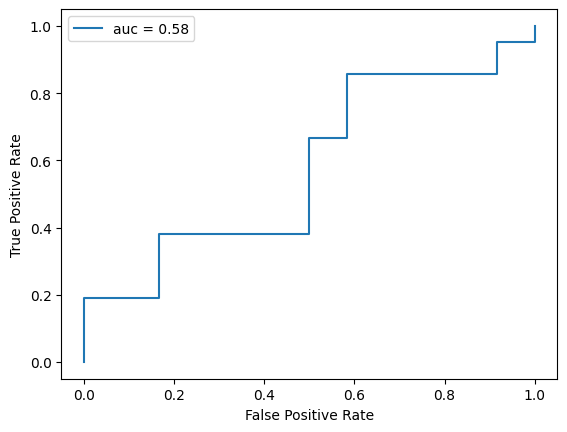

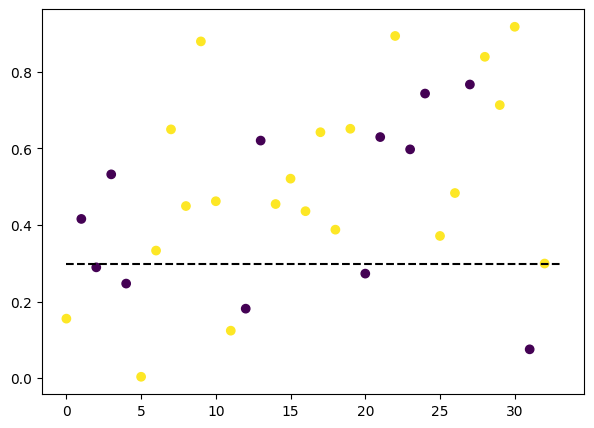

In [111]:
n = features.shape[0] # number of patients
p = features.shape[1] # number of features
# feature selection using lasso
print(f'The number of patients (n) is: {n}\nThe number of features (p) is: {p}')
# create loo using kfold
kfold = KFold(n_splits=n)
# prepare data
y = np.asarray(info.labels_list(label))
x = np.asarray(features)
# create pipeline with scaler and logistic regression
pipe = Pipeline([('scaler', StandardScaler()), ('lasso', LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', C=1, max_iter=1000))])
prob_matrix = np.zeros(shape=(n, 2))
# go through each fold
for train, test in kfold.split(features, y):
    # fit the lasso
    pipe.fit(x[train], y[train])
    # get the coefficients
    coef = pipe.named_steps['lasso'].coef_
    # get the features that are not zero
    features_selected = features.columns[coef[0] != 0]
    print(f'The number of features selected is: {len(features_selected)}')
    # predict
    prob_matrix[test] = pipe.predict_proba(x[test])


# show results
# get roc curve
fpr, tpr, thresholds = roc_curve(y, prob_matrix[:, 1])
# compute auc
auc = roc_auc_score(y, prob_matrix[:, 1])
# plot roc curve
plt.plot(fpr, tpr, label=f'auc = {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# get optimal threshold
op_threshold = best_threshold(fpr, tpr, thresholds)

# define threshold
threshold = op_threshold
# compute metrics
# accuracy
accuracy = accuracy_score(info.labels_list(label), prob_matrix[:, 1] > threshold)
print(f'Accuracy: {accuracy}')
# F1 score
f1 = f1_score(info.labels_list(label), prob_matrix[:, 1] > threshold)
print(f'F1 score: {f1}')
# precision
precision = precision_score(info.labels_list(label), prob_matrix[:, 1] > threshold)
print(f'Precision: {precision}')
# sensitivity (recall, TPR)
sensitivity = recall_score(info.labels_list(label), prob_matrix[:, 1] > threshold)
print(f'Sensitivity: {sensitivity}')
# specificity (TNR)
specificity = recall_score(info.labels_list(label), prob_matrix[:, 1] > threshold, pos_label=0)
print(f'Specificity: {specificity}')
# MCC
mcc = matthews_corrcoef(info.labels_list(label), prob_matrix[:, 1] > threshold)
print(f'MCC: {mcc}')

# plot prediciton values, with their corresponding labels in color
plt.figure(figsize=(7,5))
plt.scatter(range(len(info.labels_list(label))), prob_matrix[:, 1],c=info.labels_list(label))
# plot threshold line
plt.plot([0, len(info.labels_list(label))], [threshold, threshold], 'k--')

## Testing with budget

Accuracy: 0.8181818181818182
F1 score: 0.8846153846153846
Precision: 0.92
Sensitivity: 0.8518518518518519
Specificity: 0.6666666666666666
MCC: 0.4666666666666667


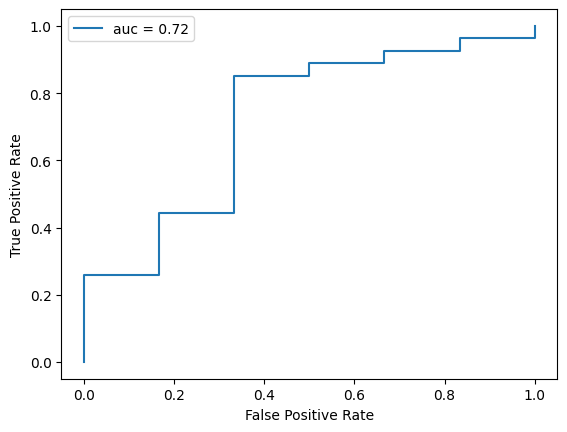

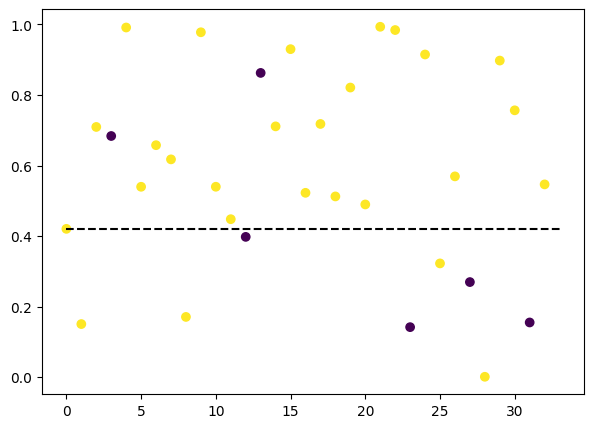

In [84]:
n = features.shape[0] # number of patients
p = features.shape[1] # number of features
# feature selection using lasso
print(f'The number of patients (n) is: {n}\nThe number of features (p) is: {p}')
# create loo using kfold
kfold = KFold(n_splits=n)
# prepare data
y = np.asarray(info.labels_list(label))
x = np.asarray(features)
# create pipeline with scaler and logistic regression
pipe = Pipeline([('scaler', StandardScaler()), ('lasso', LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', C=1, max_iter=1000))])
prob_matrix = np.zeros(shape=(n, 2))
# go through each fold
for train, test in kfold.split(features, y):
    # fit the lasso
    pipe.fit(x[train], y[train])
    # get the coefficients
    coef = pipe.named_steps['lasso'].coef_
    # get the features that are not zero
    features_selected = features.columns[coef[0] != 0]
    print(f'The number of features selected is: {len(features_selected)}')
    # predict
    prob_matrix[test] = pipe.predict_proba(x[test])


# show results
# get roc curve
fpr, tpr, thresholds = roc_curve(y, prob_matrix[:, 1])
# compute auc
auc = roc_auc_score(y, prob_matrix[:, 1])
# plot roc curve
plt.plot(fpr, tpr, label=f'auc = {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# get optimal threshold
op_threshold = best_threshold(fpr, tpr, thresholds)

# define threshold
threshold = op_threshold
# compute metrics
# accuracy
accuracy = accuracy_score(info.labels_list(label), prob_matrix[:, 1] > threshold)
print(f'Accuracy: {accuracy}')
# F1 score
f1 = f1_score(info.labels_list(label), prob_matrix[:, 1] > threshold)
print(f'F1 score: {f1}')
# precision
precision = precision_score(info.labels_list(label), prob_matrix[:, 1] > threshold)
print(f'Precision: {precision}')
# sensitivity (recall, TPR)
sensitivity = recall_score(info.labels_list(label), prob_matrix[:, 1] > threshold)
print(f'Sensitivity: {sensitivity}')
# specificity (TNR)
specificity = recall_score(info.labels_list(label), prob_matrix[:, 1] > threshold, pos_label=0)
print(f'Specificity: {specificity}')
# MCC
mcc = matthews_corrcoef(info.labels_list(label), prob_matrix[:, 1] > threshold)
print(f'MCC: {mcc}')

# plot prediciton values, with their corresponding labels in color
plt.figure(figsize=(7,5))
plt.scatter(range(len(info.labels_list(label))), prob_matrix[:, 1],c=info.labels_list(label))
# plot threshold line
plt.plot([0, len(info.labels_list(label))], [threshold, threshold], 'k--')